In [1]:
import sys
kaggle_path = ['../Data/Kaggle/train/*']
sys.path.append('../')
from First_start.imports import *
from First_start.multi_gpu import *
from First_start.init_vars import *
from First_start.start_functions import *
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Imports imported
multi_gpu imported
Vars initialized (FISH_DICTS, seed)


In [2]:
import math
%matplotlib inline

In [189]:
def get_xy(folders_paths=['../Data/Kaggle/train/*', '../Data/Imagenet/*'],
           test_size=0.0, img_size=(224, 224), seed=7):
    """Retrieves all data from a folders_path and gives back
    x_train, x_test, y_train, y_test
    folders_path: The folder to the data (standard: '../Data/Kaggle/train/*')
    img_size: size of the image (standard: (224, 224))
    split: Where to make the split between training and test data
    """
    # creating a dataframe with the columns below
    image_dict = {}

    # going through all folders and saving file names in dataframe so that order is always correct
    for folders_path in folders_paths:
        for foldername in glob.glob(folders_path):
            for image_name in glob.glob(foldername + '/*.jpg'):
                # getting image name and fish type and putting it in a dictionary
                fish_type = foldername.split('/')[-1]
                image_dict[image_name] = fish_type
            
        assert image_dict, 'Files not found in {}'.format(folders_path)

    # image_df: image_name | fish_type
    # NOTE: Change sampling back to 1 once model is done
    image_df = pd.DataFrame({'image': list(image_dict.keys()), 'fish_type': list(image_dict.values())}).sample(frac=0.25)   
    
    # dummy_df: dummy version of image_df
    dummy_df = pd.get_dummies(image_df, columns=['fish_type']) # dummify data
    
    # Create list with images as arrays
    images = np.array([cv2.imread(img) for img in dummy_df.image])   
    images = [cv2.resize(img, img_size, cv2.INTER_LINEAR) for img in images]

    # X and y value and labels
    x = images
    y = dummy_df.iloc[:,1:9].as_matrix()

    # Split dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
    
    x_train, x_test, y_train, y_test = np.asarray(x_train), np.asarray(x_test), np.asarray(y_train), np.asarray(y_test)
    
    
    # Return stuff
    return x_train, y_train, x_test, y_test, image_df, dummy_df


def get_final_test(files_path='../Data/Kaggle/test1/*.jpg', img_size=(224, 224)):
    """Gets final test data
    """
    # going through all folders and saving file names in list so that order is always correct
    x_test_names = glob.glob(files_path)
    x_test = np.asarray([cv2.resize(cv2.imread(name), (224, 224), cv2.INTER_LINEAR) for name in x_test_names])
    
    # Return stuff
    return x_test_names, x_test

In [190]:
# Get x and y variables
test_size = (672, 448)
x_train, y_train, x_test, y_test, image_df, dummy_df = get_xy(folders_paths=kaggle_path, test_size=0.3,
                                                              img_size=test_size, seed=seed)

# Let's check the shape of those variables
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(660, 448, 672, 3) (660, 8) (284, 448, 672, 3) (284, 8)


In [191]:
x_train_cropped = np.zeros(shape=(660,224,224,3)).astype('uint8')

In [126]:
def long_slice(image, slice_size):
    """
    
    """
    best_score = 0.0
    best_slice = None
    steps_per_slice = 3
    hor_slices = int(image.shape[0]/slice_size) * steps_per_slice - 1
    ver_slices = int(image.shape[1]/slice_size) * steps_per_slice - 1
    step_size = int(float(slice_size)/steps_per_slice)
    for hor_ind in range(hor_slices):
        for ver_ind in range(ver_slices):
#             print(hor_ind*step_size,hor_ind*step_size+slice_size, ver_ind*step_size,ver_ind*step_size+slice_size)
            current_slice = image[hor_ind*step_size:hor_ind*step_size+slice_size,
                                  ver_ind*step_size:ver_ind*step_size+slice_size,:]
            current_slice = cv2.resize(current_slice, (224, 224), cv2.INTER_LINEAR)
#             plt.imshow(current_slice);
#             plt.show();
#             print(current_slice.astype(float).reshape(-1,224,224,3))
            preds = model.predict(imagenet_utils.preprocess_input(current_slice.astype(float).reshape(-1,224,224,3)))
            preds = imagenet_utils.decode_predictions(preds)
            score = 0.0
            for i in preds[0]:
                if i[1] in fish_set and i[2] > score:
                    score = i[2]
            if score > best_score:
                best_score = score
                best_slice = current_slice
    return best_score, best_slice
#     print(best_score)
#     plt.imshow(best_slice);
#     plt.show();

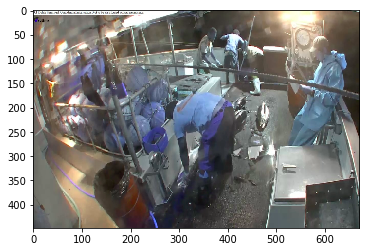

In [119]:
plt.imshow(x_train[0,:,:,:]);

0.044146


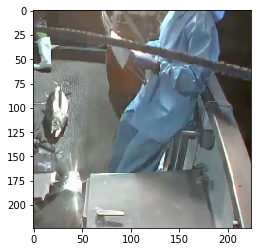

In [122]:
long_slice(x_train[0,:,:,:], 224)

In [6]:
from keras.applications import imagenet_utils

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

<function keras.applications.imagenet_utils.preprocess_input>

In [115]:
fish_set = ('tench', 'goldfish', 'grey_whale', 'killer_whale', 'dugong', 'great_white_shark', 'tiger_shark', 'barracouta', 'eel', 'coho', 'rock_beauty', 'anemone_fish', 'sturgeon', 'gar', 'hammerhead')
# fish_set = ('tench', 'goldfish', 'jellyfish', 'grey_whale', 'killer_whale', 'dugong', 'great_white_shark', 'tiger_shark', 'barracouta', 'eel', 'coho', 'rock_beauty', 'anemone_fish', 'sturgeon', 'gar', 'lionfish', 'puffer', 'hammerhead', 'stingray')

In [197]:
for i in range(x_train.shape[0]):
# for i in range(10):
    if (i % 25 == 0):
        print(i)
#     plt.imshow(x_train[i,:,:,:]);
#     plt.show();
    best_score = 0
    best_slice = None
    window_sizes = (224,)
    for size in window_sizes:
        current_score, current_slice = long_slice(x_train[i,:,:,:], size)
        if current_score > best_score:
            best_score = current_score
            best_slice = current_slice
    if best_score > 0:
        x_train_cropped[i,:,:,:] = best_slice.astype('uint8')
    else:
        x_train_cropped[i,:,:,:] = cv2.resize(x_train[i,:,:,:], (224, 224), cv2.INTER_LINEAR)
#     print(best_score)
#     if best_score > 0:
#         plt.imshow(best_slice);
#         plt.show();

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650


In [196]:
np.save('../Data/x-cropped-0.05-sample.npy', x_train_cropped)
np.save('../Data/y-0.05-sample.npy', y_train)

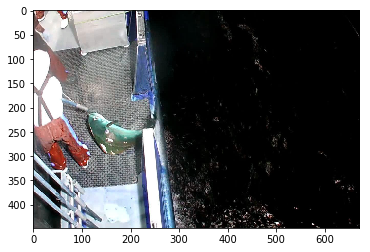

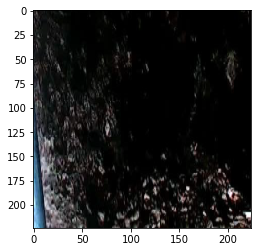

In [210]:
plt.imshow(x_train[15,:,:,:]);
plt.show();
plt.imshow(x_train_cropped[15,:,:,:]);
plt.show();